In [1]:
import itertools
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from irls.irls import LogisticRegression
from scipy.special import expit

SEED = 123

# Empirical tests of IRLS solver for logistic regression
**Advanced Machine Learning - Project 1**

## Simple scenario without interactions

Classes are not linearly separable.

In [2]:
rng = np.random.default_rng(SEED)
ps = [1, 2, 3, 4, 5, 7, 12, 18, 25, 45, 75]
ns = [100, 200, 500, 1000]
results = []
for p in ps:
    for n in ns:
        beta = rng.uniform(-10,10, (p+1))
        X_train = rng.normal(size=(n, p))
        proba = expit(beta[0] + beta[1:] @ X_train.transpose())
        y_train = rng.binomial(1, proba)
        model = LogisticRegression().fit(X_train, y_train)

        X_test = rng.normal(size=(n, p))
        proba = expit(beta[0] + beta[1:] @ X_test.transpose())
        y_test = rng.binomial(1, proba)
        y_hat = model.predict(X_test)
        acc = np.sum(y_hat == y_test) / n
        results += [{
            'p': p,
            'n': n,
            'accuracy': acc
        }]
results = pd.DataFrame(results).pivot(index='n', columns='p', values='accuracy')

<Axes: xlabel='p', ylabel='n'>

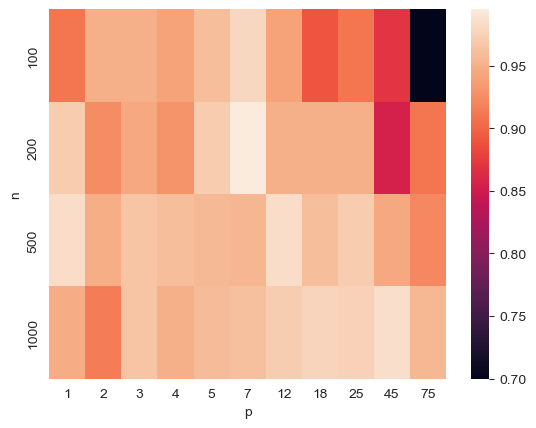

In [3]:
sns.heatmap(results)

## Simple scenario with interactions

Classes are not linearly separable.

In [4]:
rng = np.random.default_rng(SEED)
ps = [2, 3, 4, 5, 7, 12, 18]
ns = [100, 200, 500, 1000]
results = []
for p in ps:
    for n in ns:
        interactions = np.stack([i for i in itertools.combinations(range(p), 2)])
        beta = rng.uniform(-10,10, (p+len(interactions)+1))
        X_train = rng.normal(size=(n, p))
        new_cols = np.stack([X_train[:, pair[0]] * X_train[:, pair[1]] for pair in interactions], axis=1)
        X = np.hstack([X_train, new_cols])
        proba = expit(beta[0] + beta[1:] @ X.transpose())
        y_train = rng.binomial(1, proba)
        model = LogisticRegression().fit(X_train, y_train, interactions=interactions)

        X_test = rng.normal(size=(n, p))
        new_cols = np.stack([X_test[:, pair[0]] * X_test[:, pair[1]] for pair in interactions], axis=1)
        X = np.hstack([X_test, new_cols])
        proba =expit(beta[0] + beta[1:] @ X.transpose())
        y_test = rng.binomial(1, proba)
        y_hat = model.predict(X_test)
        acc = np.sum(y_hat == y_test) / n
        results += [{
            'p': p,
            'n': n,
            'accuracy': acc
        }]
results = pd.DataFrame(results).pivot(index='n', columns='p', values='accuracy')

<Axes: xlabel='p', ylabel='n'>

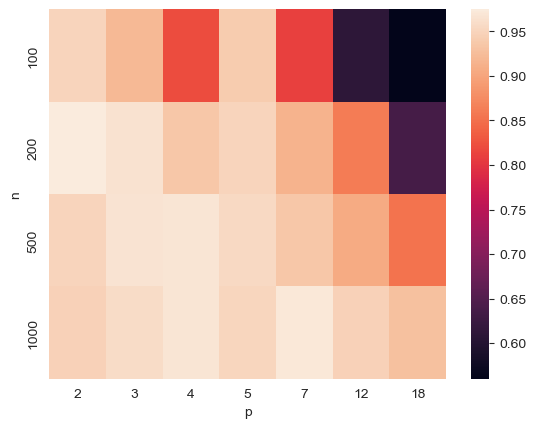

In [5]:
sns.heatmap(results)

## Visualization of convergence

In [6]:
%matplotlib inline

rng = np.random.default_rng(SEED)
n = 200
p = 2
beta = [-5, -1, 12]
X = np.vstack([rng.normal(size=(n, p)), rng.normal(loc=3, size=(n, p))])
proba = expit(beta[0] + beta[1:] @ X.transpose())
y = rng.binomial(1, proba)

model = LogisticRegression(optimizer='IRLS').fit(X, y)
y_hat = model.predict(X)

xx, yy = np.meshgrid(np.linspace(-4, 7, 150), np.linspace(-4, 7, 150))
betas = model.theta_history()

fig, ax = plt.subplots(1,1)

def animate(i):
    ax.clear()
    b = betas[i]
    proba = expit(b[0] + b[1:] @ np.c_[xx.ravel(), yy.ravel()].transpose())
    proba = proba.reshape(xx.shape)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#d73027', '#1a9850']))
    ax.contourf(xx, yy, proba, levels=[0.2*i for i in range(6)], alpha=0.3, cmap='RdYlGn')
    ax.set_title(f"Probability estimation in iteration {i} of IRLS\nestimated beta={np.round(b, 2)}")


ani = animation.FuncAnimation(fig, animate, interval=1, frames=len(betas), repeat=False)
c = plt.contourf(xx, yy, expit(beta[0] + beta[1:] @ np.c_[xx.ravel(), yy.ravel()].transpose()).reshape(xx.shape),
                 levels=[0.2*i for i in range(6)], alpha=0.3, cmap='RdYlGn')
plt.colorbar()
plt.close()

# Save the animation as an animated GIF
ani.save("simple_animation.gif", dpi=300,
         writer=animation.PillowWriter(fps=0.5))